<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implement-a-matrix-factorisation-using-gradient-descent" data-toc-modified-id="Implement-a-matrix-factorisation-using-gradient-descent-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implement a matrix factorisation using gradient descent</a></span><ul class="toc-item"><li><span><a href="#Implement-gradient-based-factorisation-(1-mark)" data-toc-modified-id="Implement-gradient-based-factorisation-(1-mark)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Implement gradient-based factorisation (1 mark)</a></span></li><li><span><a href="#Factorise-and-compute-reconstruction-error-(1-mark)" data-toc-modified-id="Factorise-and-compute-reconstruction-error-(1-mark)-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Factorise and compute reconstruction error (1 mark)</a></span></li></ul></li><li><span><a href="#Compare-your-result-to-truncated-SVD" data-toc-modified-id="Compare-your-result-to-truncated-SVD-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare your result to truncated SVD</a></span></li><li><span><a href="#Matrix-completion" data-toc-modified-id="Matrix-completion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Matrix completion</a></span></li></ul></div>

# Lab 1 Exercise - Playing with gradients and matrices in PyTorch

In [1]:
import numpy as np
import torch
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple
sns.set()

## Implement a matrix factorisation using gradient descent

### Implement gradient-based factorisation (1 mark)

In [2]:
m, n, rank = 10, 12, 8
A = torch.randn(m, n)

In [12]:
def sgd_foctorise(A, rank, num_epochs=1000, lr=0.01) -> Tuple[torch.Tensor, torch.Tensor]:
    m, n = A.shape[0], A.shape[1]
    U = torch.randn(m, rank)
    V = torch.randn(n, rank)
    Eplot = np.zeros((num_epochs, 1))
    Eplot2 = np.zeros((num_epochs, 1))
    for epoch in range(num_epochs):
        losses, errors = [], []
        for r in range(m):
            for c in range(n):
                e = A[r][c] - U[r] @ V[c].t()
                U[r] = U[r] + lr*e*V[c]
                V[c] = V[c] + lr*e*U[r]
                errors.append(e)
        Eplot[epoch] = torch.nn.functional.mse_loss(A, U @ V.t(), reduction='sum').detach().numpy()
        Eplot2[epoch] = sum(errors)/(m*n)
                
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(Eplot)
    plt.title("Matrix Factorisation using Gradient Descent (Loss)", fontsize=20)
    plt.xlabel("Iteration Number", fontsize=18)
    plt.ylabel("Residual Loss", fontsize=18)
    plt.savefig("MFGDloss.svg", format='svg', dpi=1200, bbox_inches='tight')
    plt.show()
    print("Final Loss:", Eplot[len(Eplot)-1])
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(Eplot2)
    plt.title("Matrix Factorisation using Gradient Descent (Error)", fontsize=20)
    plt.xlabel("Iteration Number", fontsize=18)
    plt.ylabel("Residual Error", fontsize=18)
    plt.savefig("MFGDError.svg", format='svg', dpi=1200, bbox_inches='tight')
    plt.show()
    
    return U, V

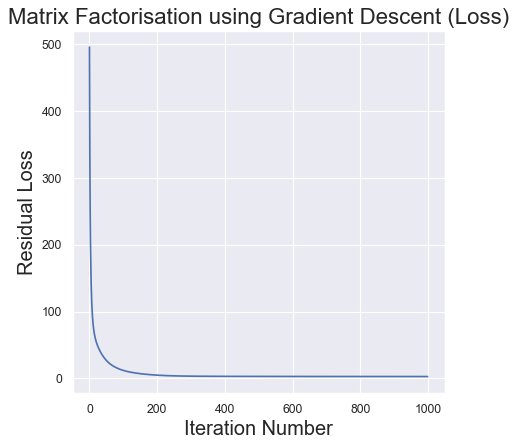

Final Loss: [2.65277052]


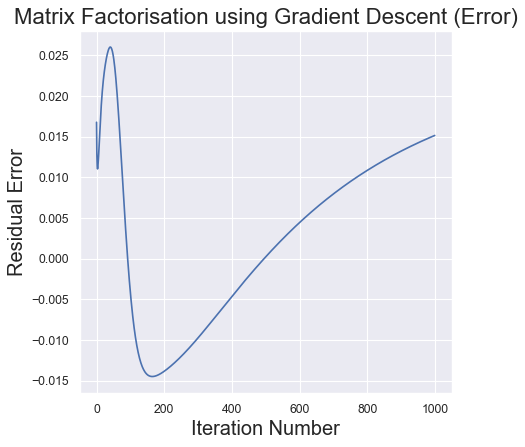

In [13]:
U, V = sgd_foctorise(A, rank, num_epochs=1000, lr=0.01)

### Factorise and compute reconstruction error (1 mark)

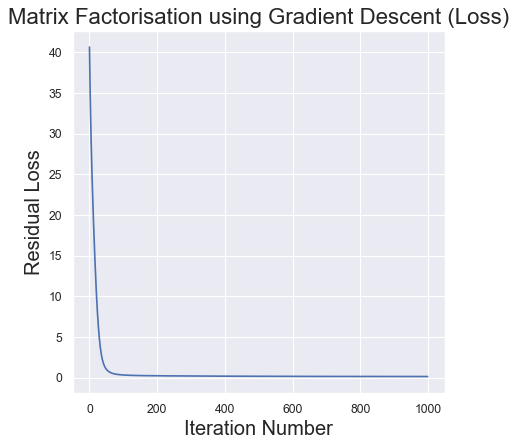

Final Loss: [0.12655814]


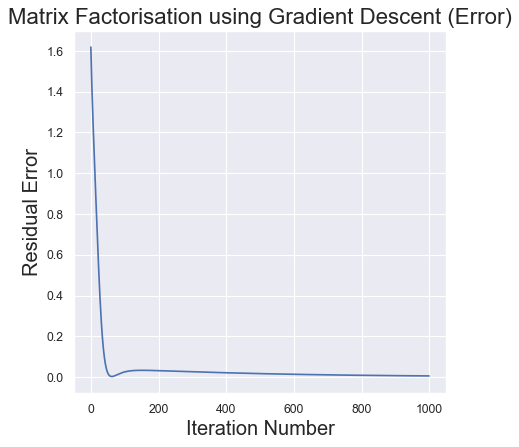

In [14]:
Anew = torch.tensor([[0.3374, 0.6005, 0.1735], 
                  [3.3359, 0.0492, 1.8374],
                  [2.9407, 0.5301, 2.2620]])

Unew, Vnew = sgd_foctorise(Anew, rank=2, num_epochs=1000, lr=0.01)

In [15]:
Anew

tensor([[0.3374, 0.6005, 0.1735],
        [3.3359, 0.0492, 1.8374],
        [2.9407, 0.5301, 2.2620]])

In [16]:
Aapprox = Unew@ Vnew.t()
Aapprox
#er = Anew - Aapprox
#er

tensor([[ 0.2225,  0.4547,  0.3690],
        [ 3.2726, -0.0309,  1.9452],
        [ 3.0167,  0.6267,  2.1326]])

In [17]:
torch.nn.functional.mse_loss(Anew, Aapprox, reduction='sum')

tensor(0.1266)

## Compare your result to truncated SVD

In [18]:
U, S, V = torch.svd(Anew)
S[2] = 0.0
A_inv_svd = U @ torch.diag(S) @ V.t()
A_inv_svd

tensor([[ 0.2245,  0.5212,  0.3592],
        [ 3.2530, -0.0090,  1.9737],
        [ 3.0378,  0.5983,  2.1023]])

In [19]:
torch.nn.functional.mse_loss(Anew, A_inv_svd, reduction='sum')

tensor(0.1219)

[Eckart-Young theorem](https://en.wikipedia.org/wiki/Low-rank_approximation)

if $rank(B)=k$, then $∥A−B∥_{2} ≥ ∥A−A_{k}∥_{2} $

## Matrix completion

In [63]:
def sgd_foctorise_masked(A, M, rank, num_epochs=1000, lr=0.01) -> Tuple[torch.Tensor, torch.Tensor]:
    m, n = A.shape[0], A.shape[1]
    U = torch.randn(m, rank)
    V = torch.randn(n, rank)
    Eplot = np.zeros((num_epochs, 1))
    for epoch in range(num_epochs):
        count = 0
        errors = []
        for r in range(m):
            for c in range(n):
                if M[r][c] != 0:
                    e = A[r][c] - U[r] @ V[c].t()
                    U[r] = U[r] + lr*e*V[c]
                    V[c] = V[c] + lr*e*U[r]
                    count += 1
                    errors.append(e)
        Eplot[epoch] = sum(errors)/count
    
    print("Final Error: ", Eplot[len(Eplot)-1])
    plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(Eplot)
    plt.title("Matrix Completition using Gradient Descent", fontsize=20)
    plt.xlabel("Iteration Number", fontsize=18)
    plt.ylabel("Residual Error", fontsize=18)
    plt.savefig("Masked.svg", format='svg', dpi=1200, bbox_inches='tight')
    plt.show()
    return U, V

Final Error:  [-2.78864576e-07]


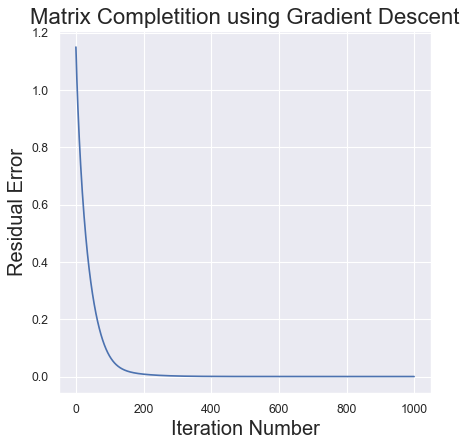

In [148]:
A = torch.tensor([[0.3374, 0.6005, 0.1735], 
                  [np.nan, 0.0492, 1.8374],
                  [2.9407, np.nan, 2.2620]])

mask = []
for i in range(0, A.shape[0]):
    for j in range(0, A.shape[1]):
        if torch.isnan(A[i][j]) != 1:
            mask.append(1)
        else:
            mask.append(0)

mask = np.array(mask).reshape(A.shape[0], A.shape[1])
Unew, Vnew = sgd_foctorise_masked(A, mask, rank=2, num_epochs=1000, lr=0.01)

In [149]:
Aapprox = Unew@ Vnew.t()
Aapprox

tensor([[ 0.3374,  0.6005,  0.1736],
        [ 2.4653,  0.0492,  1.8373],
        [ 2.9407, -0.4789,  2.2621]])

In [150]:
torch.nn.functional.mse_loss(Anew, Aapprox, reduction='sum')

tensor(1.7759)